## Analysis of a two-grid method for the curl-curl equation using the ``half-hybrid`` smoother

In here we use this framework to analyze the half hybrid smoother for the curl-curl equation as described in https://epubs.siam.org/doi/abs/10.1137/S0036142997326203, and analyzed in https://epubs.siam.org/doi/abs/10.1137/070679119.

It corresponds to section 6.2 of the aLFA paper: https://arxiv.org/abs/1811.01783

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import alfa

In [2]:
# define operators...
L = alfa.gallery.operators.curlcurl(.01)  # sigma = .01
I = alfa.tools.identity(L.C)  # identity
R = alfa.gallery.operators.curlcurl_restriction()
P = R.transpose()  # prolongation
Lc = R@L@P  # coarse grid oeprator

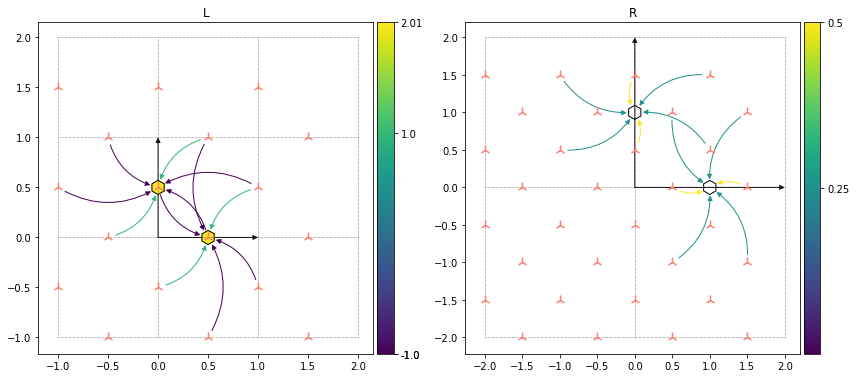

In [3]:
# plot L and R
plt.figure()
plt.gcf().set_figwidth(12)
plt.gcf().set_figheight(12)
plt.subplot(121)
L.plot()
plt.title("L")
plt.subplot(122)
R.plot()
plt.title("R")
plt.tight_layout()

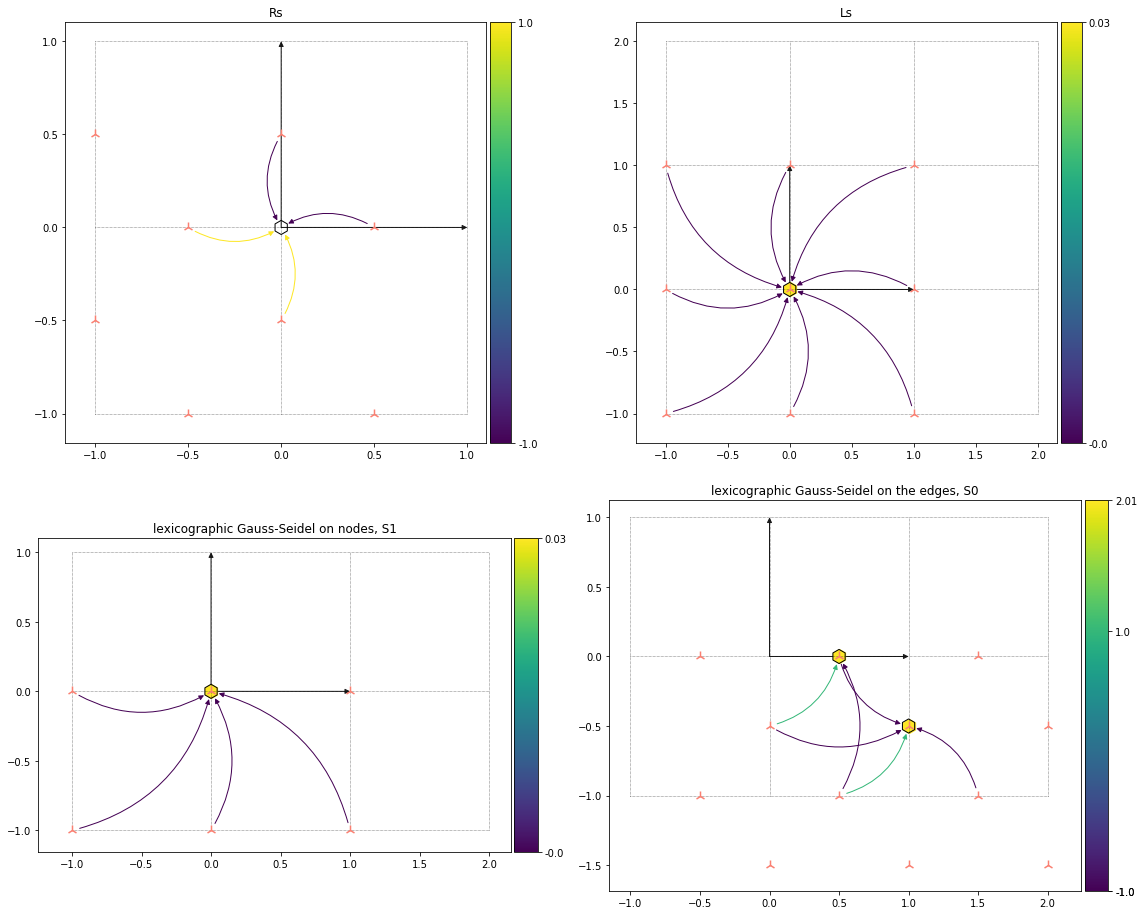

In [4]:
# hybrid Smoother.
# first: restriction operator (discrete gradient operator)
A = np.eye(2)
s0 = np.asarray([[.5, 0], [0, .5]])
s = [s0, np.asarray([[0, 0]])]
C = alfa.Crystal(A, s)
Rs = alfa.Operator(C)
Rs.add_multiplier(np.asarray([[1, 0]]), np.asarray([-1, 0]))
Rs.add_multiplier(np.asarray([[-1, -1]]), np.asarray([0, 0]))
Rs.add_multiplier(np.asarray([[0, 1]]), np.asarray([0, -1]))

# Prolongation operator
Ps = Rs.transpose()
# coarse grid operator
Ls = Rs@L@Ps

# Gauss Seidel on the vertices
# We have to extract all multipliers m_{Ls}^(X) with X = (X_1, X_2) <= 0.
# This is done with the function "alfa.tools.lower_triangle_of".
# In the paper they use the lexicographic ordering
# ((X_1, X_2) <= (Y_1, Y_2)) <=> (X_2 < Y_2 OR (X_2 = Y_2 AND X_1 <= Y_1)),
# whereas the standard lexicographic is defined as
# ((X_1, X_2) <= (Y_1, Y_2)) <=> (X_1 < Y_1 OR (X_1 = Y_1 AND X_2 <= Y_2)).
# Thus, we have to redefine the lexicographic comparison by passing a permutation (permute_lex_ordering)
# to this function.
permute_lex_ordering = [1, 0]
S1 = alfa.tools.lower_triangle_of(Ls, None, permute_lex_ordering)

###########################################################
# and scalar Gauss-Seidel the edges:

# In order to obtain exactly the same ordering as in the paper,
# things get a bit complicated. Cf. Figure 6.1 In https://epubs.siam.org/doi/abs/10.1137/070679119.

# Locally, the ordering in the paper is as follows:
# We first udpate a horizontal edge at ([.5, 0]), before we update the vertical edge at [1.0, -.5]
# Thus, we need to rewrite this operator with respect to this modified structure element.
s0_lex = np.asarray([[.5, 0], [1.0, -.5]])
L_lex = L.change_structure_elements([s0_lex, s0_lex])  # A similar

# Next, we extract all multipliers with m_{L_lex}^(X) with X = (X_1, X_2) <= 0.
# The resulting operator corresponds to block-Gauss-Seidel.
S0 = alfa.tools.lower_triangle_of(L_lex, None, permute_lex_ordering)
# Using the lower triangle of the central block corresponds to scalar Gauss-Seidel.
# The position of multiplier "2" S0.m[2].pos is [0,0], i.e. it is the central multiplier.
S0.m[2].matrix = np.tril(S0.m[2].matrix)
###########################################################

# some plots of the constructed operators
plt.figure()

plt.subplot(221)
Rs.plot()
plt.title("Rs")
plt.subplot(222)
Ls.plot()
plt.title("Ls")
plt.subplot(223)
S1.plot()
plt.title("lexicographic Gauss-Seidel on nodes, S1")
plt.subplot(224)
S0.plot()
plt.title("lexicographic Gauss-Seidel on the edges, S0")

plt.gcf().set_figwidth(16)
plt.gcf().set_figheight(13)
plt.tight_layout()

In [5]:
# Construct the error propagator of the smoother and the two-grid correction as a string.
# This string is evaluated on the level of symbols.
X = {x: eval(x) for x in ['I', 'L', 'S0', 'Ps', 'S1', 'Rs', 'P', 'Lc', 'R']}


# Construct smoother string GE.
GEstr = "('I' - pinv('S0')@'L')"
GNstr = "('I' - 'Ps'@pinv('S1')@'Rs'@'L')"

# construct coarse grid correction
Kstr = "('I' - 'P'@pinv('Lc')@'R'@'L')"

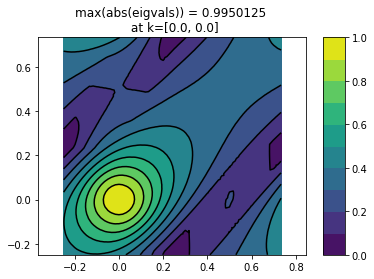

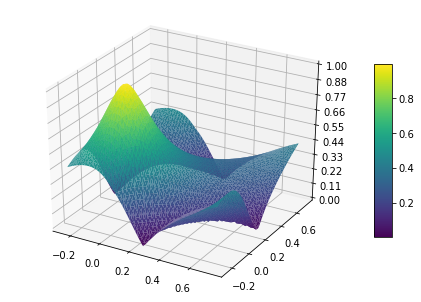

In [6]:
# Remark:
# The plots/results depend heavily on the lexicographic ordering of the unknowns in the
# Gauss-Seidel methods in pre and post-smoothing.

# analysis of the smoother.
smoother = alfa.Operator_Composition(X,    GNstr + '@' + GEstr)
# discretize A^{-T}[-1/4,3/4)^2 using 60^2 points.
smoother.discretize_frequency_space(60, [-1/4, 3/4])
smoother.compute_spectrum()

# plot...
plt.figure()
# contour plot levels 0, .1, .2, ... , 1.0
smoother.plot_spectrum(np.inf, np.linspace(0, 1, 11))
plt.figure()
smoother.plot_spectrum_3d()

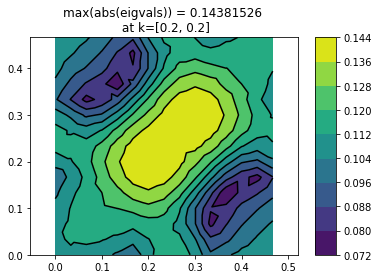

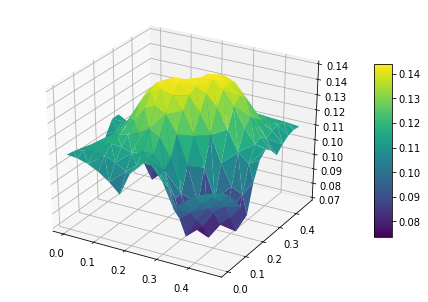

In [7]:
# analysis of the two-grid method.

# We don't obtain the same convergence rate as in the
# paper https://epubs.siam.org/doi/abs/10.1137/070679119.
# We suspect, that they use a different ordering in pre/post-smoothing.
twogrid = alfa.Operator_Composition(
    X, GNstr + '@' + GEstr + '@' + Kstr + '@' + GNstr + '@' + GEstr)
twogrid.compute_spectrum(15)  

# plot...
plt.figure()
twogrid.plot_spectrum()
plt.figure()
twogrid.plot_spectrum_3d()

# Prototyping the two-grid method to double check our result

In [8]:
# construct matrices from the operators by rewriting them w.r.t a large translational invariance and taking the sum of all multipliers.

X_prototype = {x: X[x].wrt_lattice(alfa.Lattice(30*np.eye(2))) for x in X}
for key in X_prototype:
    # normalize structure elements, i.e., shift into Z[0,1)^2 and sort lexicographically.
    X_prototype[key].normalize()
    # create matrices by summing up all multipliers (We have periodic boundary conditions)
    X_prototype[key] = sparse.csc_matrix(
        sum([x.matrix for x in X_prototype[key].m]))

In [9]:
# definition of the iterative update schemes within the two-grid method.

from scipy.sparse import linalg

# Compute the pseudoinverse of S and L_c
S_Node_mat_lu = linalg.splu(X_prototype['S1'])

S_Edge_mat_lu = linalg.splu(X_prototype['S0'])

Lc_mat_lu = linalg.splu(X_prototype['Lc'])

# Definition of the smoothing,


def smooth_edge(b, x):
    r = b-(X_prototype['L']@x)  # compute the residual
    x += S_Edge_mat_lu.solve(r)  # compute and add the correction
    return x


def smooth_node(b, x):
    r = b-(X_prototype['L']@x)  # compute the residual
    r_c = X_prototype['Rs']@r  # restrict to coarse grid
    x_c = S_Node_mat_lu.solve(r_c)  # solve coarse grid problem
    # prolongate to fine grid and add to current iterate.
    x += X_prototype['Ps']@x_c
    return x

# Definition of the coarse grid correction.


def cgc(b, x):
    r = b-(X_prototype['L']@x)  # compute the residual
    r_c = X_prototype['R']@r  # restrict to coarse grid
    x_c = Lc_mat_lu.solve(r_c)  # solve coarse grid problem
    # prolongate to fine grid and add to current iterate.
    x += X_prototype['P']@x_c
    return x

The measured asymptotic convergence rate is: 0.1436631091199594


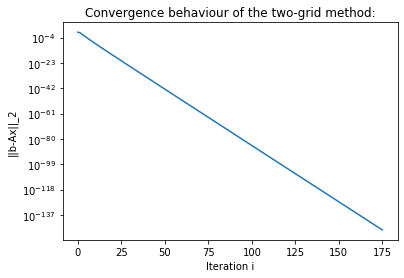

In [10]:
# running the two-grid method
n = X_prototype['L'].shape[0]
# initialize right hand side and initial guess.
x = np.asarray(X_prototype['L']@np.random.rand(
    n), dtype='complex128')  # random initial guess
x = x/np.linalg.norm(x)  # normalize the initial guess
b = np.zeros(n, dtype='complex128')  # create 0-right hand side.


it = 0
# define some lists where we save the convergence behaviour
resnorm_vec = [1]  # list of the norms of the residuals ||b-Ax_i||
# list of the current convergence rate rho_i = ||b-Ax_{i+1}|| / ||b-Ax_{i}|| <=>  ||b-Ax_{i+1}||  = rho_i ||b-Ax_{i}||
casym_vec = [1]

# the two-grid cycle
while np.linalg.norm(b - X_prototype['L']@x) > 1e-200 and it < 175:
    it += 1
    x = smooth_edge(b, x)  # smoothing step
    x = smooth_node(b, x)  # smoothing step
    x = cgc(b, x)  # coarse grid correction
    x = smooth_edge(b, x)  # smoothing step
    x = smooth_node(b, x)  # smoothing step
    # save stuff in each iterate
    resnorm_vec.append(np.linalg.norm(b - X_prototype['L']@x))
    casym_vec.append(resnorm_vec[-1] / resnorm_vec[-2])


plt.figure()
plt.semilogy(resnorm_vec)
plt.xlabel('Iteration i')
plt.ylabel('||b-Ax||_2')
plt.title('Convergence behaviour of the two-grid method:')
print("The measured asymptotic convergence rate is:", casym_vec[-1])